In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits

from scipy.spatial import ConvexHull
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Plotly
from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import plotly.io as pio

In [5]:
!pip install plotly

     |████████████████████████████████| 20.6 MB 12.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [ ]:
df=pd.read_csv('V7XJ9_10min.csv')
anomalies = pd.read_csv('data/4_dfOutlier.csv',index_col='index')
iso_score = pd.read_csv('data/2_dfIso.csv',index_col='index')
preproc = pd.read_csv('data/1_preproc.csv',index_col='index')

### Postprocessing analytics

In [279]:
#route preprocessing
def routePreprocessing(df,anomalies,iso_score):
    route=df.loc[anomalies.index][['LAT','LON']]
    route['cluster']=anomalies['cluster']
    route['iso_score']=iso_score.loc[anomalies.index]['iso_score']
    route['rpm']=df.loc[anomalies.index]['ME1_RPM']
    route['speed']=df.loc[anomalies.index]['SPEED_VG']
    return route

#speed Vs Rpm
def speedRpm(df,route):   
    colorPlot = ['lightgreen','lightskyblue','plum', 'olive', 'darkorange']
    fig,ax=plt.subplots(figsize=(12,12))
    sns.kdeplot(data=df.loc[preproc.index], x="SPEED_VG", y="ME1_RPM",fill=True, ax=ax)
    sns.scatterplot(data=route, ax=ax, x='speed', y='rpm', hue = 'cluster', style="cluster", palette=colorPlot, s=75)
    plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha = 0.2)
    plt.xlabel('Speed Over Ground ($knot$)', fontsize=20)
    plt.ylabel('Engine Rotation ($rpm$)', fontsize=20)
    
def selectPlot(df, feature1, feature2, nameset1):   
    colorPlot = ['lightgreen','lightskyblue','plum', 'olive', 'darkorange']
    fig,ax=plt.subplots(figsize=(16,16))
    sns.kdeplot(data=df.loc[preproc.index], x=feature1, y=feature2, fill=True, ax=ax)
    sns.scatterplot(data=df, ax=ax, x=feature1, y=feature2, hue = 'cluster', style="cluster", palette=colorPlot, s=125)
    plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha = 0.2)
    plt.xlabel(nameset1, fontsize=20)
    plt.ylabel('Engine Rotation ($rpm$)', fontsize=20)
    
#         # draw enclosure
#     for i in np.arange(1,6,1):
#         points = df[df.cluster == i][[feature1, feature2]].values
#         # get convex hull
#         hull = ConvexHull(points)
#         # get x and y coordinates
#         # repeat last point to close the polygon
#         x_hull = np.append(points[hull.vertices,0],
#                            points[hull.vertices,0][0])
#         y_hull = np.append(points[hull.vertices,1],
#                            points[hull.vertices,1][0])
#         # plot shape
#         plt.fill(x_hull, y_hull, alpha=0.3)

    
#Plotting over time series
def timeSeries(df,preproc,route):
    preproc['speed']=df.loc[preproc.index]['SPEED_VG']
    ts=pd.merge(df,preproc,how='left',left_index=True, right_index=True)[['rpm','speed']]
    cols =['speed','rpm']
    fig,axs=plt.subplots(2,1,figsize=(20,10))
    for i,j in enumerate(cols):
        axs[i].plot(ts.index, ts[j], lw=0.5)
        sns.scatterplot(data=route, ax=axs[i], x=route.index, y=j, hue='cluster', style="cluster", color='k')
        
def plotAll(df,anomalies,preproc,iso_score):
    route = routePreprocessing(df,anomalies,iso_score)
    speedRpm(df,route)
#     timeSeries(df,preproc,route)
    return route

In [205]:
dfPlot= pd.concat([preproc, anomalies['cluster']], axis=1)
dfPlot['TIME_STAMP'], dfPlot['speed_vg'] = df['TIME_STAMP'], df['SPEED_VG']

In [206]:
dfPlot['RPM_%'] = dfPlot['rpm'] * (100/127)

In [269]:
dfPlot.iloc[[5643]].T

index                               8971
rpm                              74.2793
fo_inlet_press                    7.4725
fo_inlet_temp                    142.913
scav_air_press                   1.57617
jcw_inlet_temp                      76.8
jcw_inlet_press                  3.72727
tc1_lo_inlet_press               1.97307
tc1_lo_outlet_temp               68.9083
lo_inlet_press                    2.2785
lo_inlet_temp                      54.29
cyl_pco_outlet_temp               59.117
cyl_cfw_outlet_temp              84.8667
cyl_exh_gas_outlet_temp          354.501
cluster                                3
TIME_STAMP               2019-09-15 7:10
speed_vg                           6.805
RPM_%                            58.4877

In [270]:
dfPlot.iloc[[7734]].T

index                               14051
rpm                               73.6437
fo_inlet_press                    6.90083
fo_inlet_temp                     138.045
scav_air_press                     1.3426
jcw_inlet_temp                      71.67
jcw_inlet_press                    3.6456
tc1_lo_inlet_press                 2.0482
tc1_lo_outlet_temp                57.6467
lo_inlet_press                    2.36343
lo_inlet_temp                     45.9483
cyl_pco_outlet_temp               50.7873
cyl_cfw_outlet_temp               78.9827
cyl_exh_gas_outlet_temp           341.918
cluster                               NaN
TIME_STAMP               2019-10-21 13:50
speed_vg                          11.1617
RPM_%                             57.9871

In [237]:
def clustPlot(data,strname):

    fig=go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=data["TIME_STAMP"], y=data[strname],name=strname))

    anom = data[data['cluster'].notna()]  
    
    anom1 = anom[anom['cluster'] == 1]
    
    fig.add_trace(go.Scatter(
        x=anom1["TIME_STAMP"],
        y=anom1[strname],
        name='Cluster 1',
        mode='markers',
        marker=dict(
            color='lightgreen',
            line=dict(
                color='red',
                width=0.5)),
        
    ))    
    anom2 = anom[anom['cluster'] == 2]
    
    fig.add_trace(go.Scatter(
        x=anom2["TIME_STAMP"],
        y=anom2[strname],
        name='Cluster 2',
        mode='markers',
        marker=dict(
            color='lightskyblue',
            line=dict(
                color='red',
                width=0.5)),
    ))   
    anom3 = anom[anom['cluster'] == 3]
    
    fig.add_trace(go.Scatter(
        x=anom3["TIME_STAMP"],
        y=anom3[strname],
        name='Cluster 3',
        mode='markers',
        marker=dict(
            color='plum',
            line=dict(
                color='red',
                width=0.5)),
        
    ))    
        
    anom4 = anom[anom['cluster'] == 4]
    
    fig.add_trace(go.Scatter(
        x=anom4["TIME_STAMP"],
        y=anom4[strname],
        name='Cluster 4',
        mode='markers',
        marker=dict(
            color='olive',
            line=dict(
                color='red',
                width=0.5)),
    ))    
    anom5 = anom[anom['cluster'] == 5]
    
    fig.add_trace(go.Scatter(
        x=anom5["TIME_STAMP"],
        y=anom5[strname],
        name='Cluster 5',
        mode='markers',
        marker=dict(
            color='darkorange',
            line=dict(
                color='red',
                width=0.5)),
    ))
    

    # Add figure title
    fig.update_layout(showlegend=False,
        template = 'simple_white',
#         title_text=('Cluster Visualization'),
        xaxis=dict(mirror=True,
                ticks='outside',
                showline=True,),
                   

        yaxis = dict(mirror=True,
                ticks='outside',
                showline=True,)
                                
            
    )

    # Set x-axis title
    fig.update_xaxes(title_text="TIME_STAMP", showgrid=True)
    

    # Set y-axes titles
    fig.update_yaxes(title_text=strname, showgrid=True)

    fig.show()

In [235]:
def doubleClustPlot(data,strname, strname2):

    fig=go.Figure()

    # Add traces 1
    fig.add_trace(go.Scatter(x=data["TIME_STAMP"], y=data[strname],name=strname, xaxis="x", yaxis="y",))

    anom = data[data['cluster'].notna()]  
    
    anom1 = anom[anom['cluster'] == 1]
    
    fig.add_trace(go.Scatter(
        x=anom1["TIME_STAMP"],
        y=anom1[strname],
        name='Cluster 1',
        mode='markers',
        marker=dict(
            color='lightgreen',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x",
        yaxis="y",
        
    ))    
    anom2 = anom[anom['cluster'] == 2]
    
    fig.add_trace(go.Scatter(
        x=anom2["TIME_STAMP"],
        y=anom2[strname],
        name='Cluster 2',
        mode='markers',
        marker=dict(
            color='lightskyblue',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x",
        yaxis="y",
    ))   
    anom3 = anom[anom['cluster'] == 3]
    
    fig.add_trace(go.Scatter(
        x=anom3["TIME_STAMP"],
        y=anom3[strname],
        name='Cluster 3',
        mode='markers',
        marker=dict(
            color='plum',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x",
        yaxis="y",
        
    ))    
        
    anom4 = anom[anom['cluster'] == 4]
    
    fig.add_trace(go.Scatter(
        x=anom4["TIME_STAMP"],
        y=anom4[strname],
        name='Cluster 4',
        mode='markers',
        marker=dict(
            color='olive',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x",
        yaxis="y",
    ))    
    anom5 = anom[anom['cluster'] == 5]
    
    fig.add_trace(go.Scatter(
        x=anom5["TIME_STAMP"],
        y=anom5[strname],
        name='Cluster 5',
        mode='markers',
        marker=dict(
            color='darkorange',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x",
        yaxis="y",
    ))
    
    # Add traces 2
    fig.add_trace(go.Scatter(x=data["TIME_STAMP"], y=data[strname2],name=strname2, xaxis="x2", yaxis="y2"))

    anom = data[data['cluster'].notna()]  
    
    anom1 = anom[anom['cluster'] == 1]
    
    fig.add_trace(go.Scatter(
        x=anom1["TIME_STAMP"],
        y=anom1[strname2],
        name='Cluster 1',
        mode='markers',
        marker=dict(
            color='lightgreen',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x2",
        yaxis="y2"
        
    ))    
    anom2 = anom[anom['cluster'] == 2]
    
    fig.add_trace(go.Scatter(
        x=anom2["TIME_STAMP"],
        y=anom2[strname2],
        name='Cluster 2',
        mode='markers',
        marker=dict(
            color='lightskyblue',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x2",
        yaxis="y2"
    ))   
    anom3 = anom[anom['cluster'] == 3]
    
    fig.add_trace(go.Scatter(
        x=anom3["TIME_STAMP"],
        y=anom3[strname2],
        name='Cluster 3',
        mode='markers',
        marker=dict(
            color='plum',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x2",
        yaxis="y2"        
    ))    
        
    anom4 = anom[anom['cluster'] == 4]
    
    fig.add_trace(go.Scatter(
        x=anom4["TIME_STAMP"],
        y=anom4[strname2],
        name='Cluster 4',
        mode='markers',
        marker=dict(
            color='olive',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x2",
        yaxis="y2"
    ))    
    
    anom5 = anom[anom['cluster'] == 5]
    
    fig.add_trace(go.Scatter(
        x=anom5["TIME_STAMP"],
        y=anom5[strname2],
        name='Cluster 5',
        mode='markers',
        marker=dict(
            color='darkorange',
            line=dict(
                color='red',
                width=0.5)),
        xaxis="x2",
        yaxis="y2"
    ))
    

    # Add figure title
    fig.update_layout(showlegend=False,
        template = 'simple_white',
#         title_text=('Cluster Visualization'),
                      
        xaxis=dict(mirror=True,
                ticks='outside',
                showline=True,),
                      
                      
        xaxis2=dict(mirror=True,
                ticks='outside',
                showline=True,),
                   

        
        yaxis=dict(ticks='outside',
                anchor="x",
                autorange=True,
                domain=[0, 0.45],

                mirror=True,
                showline=True,
                side="left",

                type="linear",
                zeroline=False
            ),
                      
        yaxis2=dict(ticks='outside',
                anchor="x",
                autorange=True,
                domain=[0.55, 1],

                mirror=True,
                showline=True,
                side="left",

                type="linear",
                zeroline=False
                                
            ),
    )
    
    

    # Set x-axis title
    fig.update_xaxes(title_text="TIME_STAMP", showgrid=True)
    

    # Set y-axes titles
    fig.update_yaxes(showgrid=True)

    fig.show()

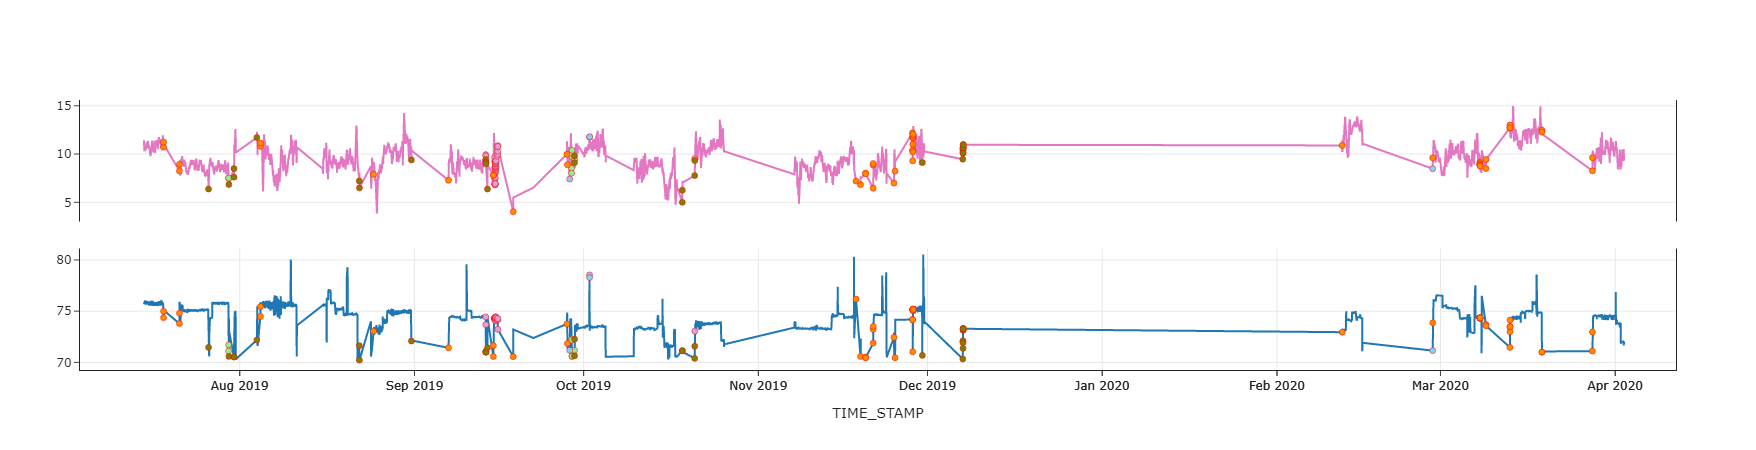

In [236]:
doubleClustPlot(dfPlot, 'rpm', 'speed_vg')

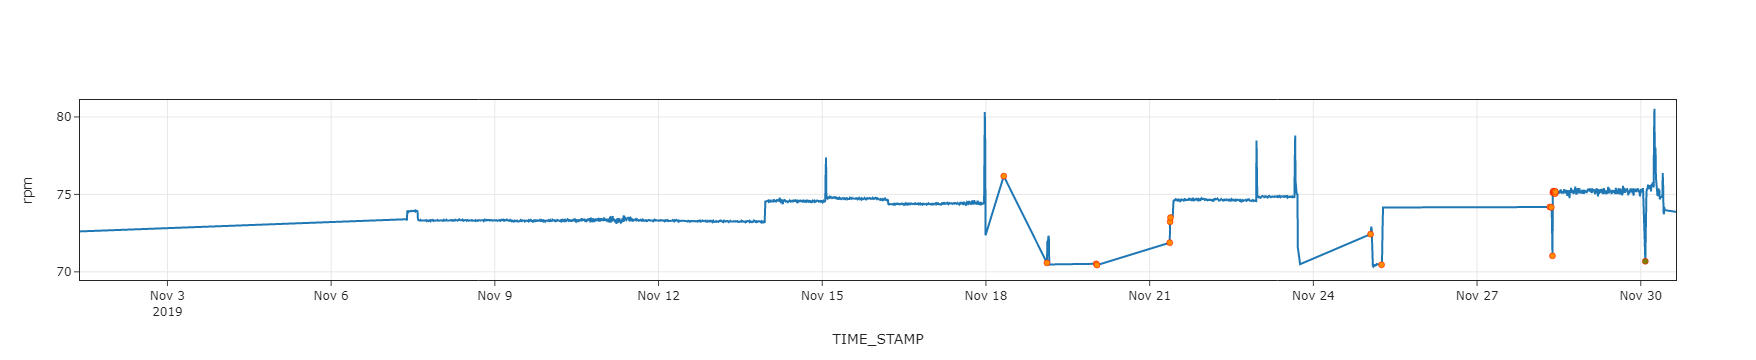

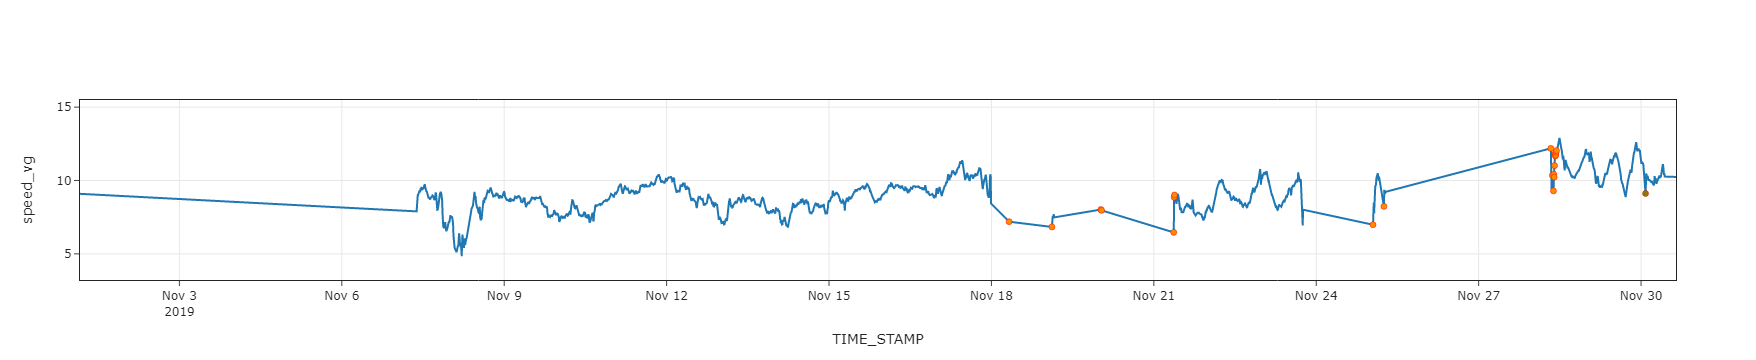

In [241]:
clustPlot(dfPlot, 'rpm')
clustPlot(dfPlot, 'speed_vg')

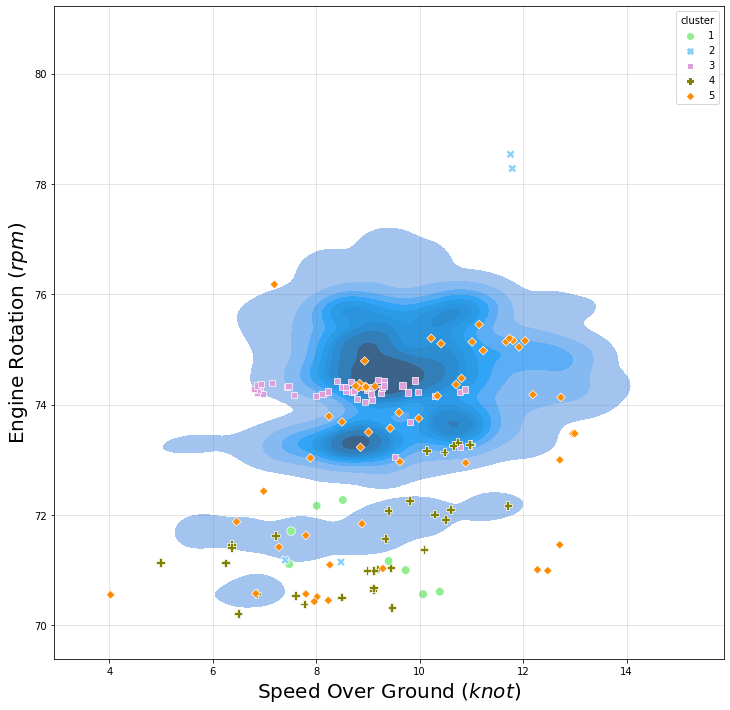

In [135]:
route = plotAll(df,anomalies,preproc,iso_score)
# plt.savefig('route.png', dpi = 400)

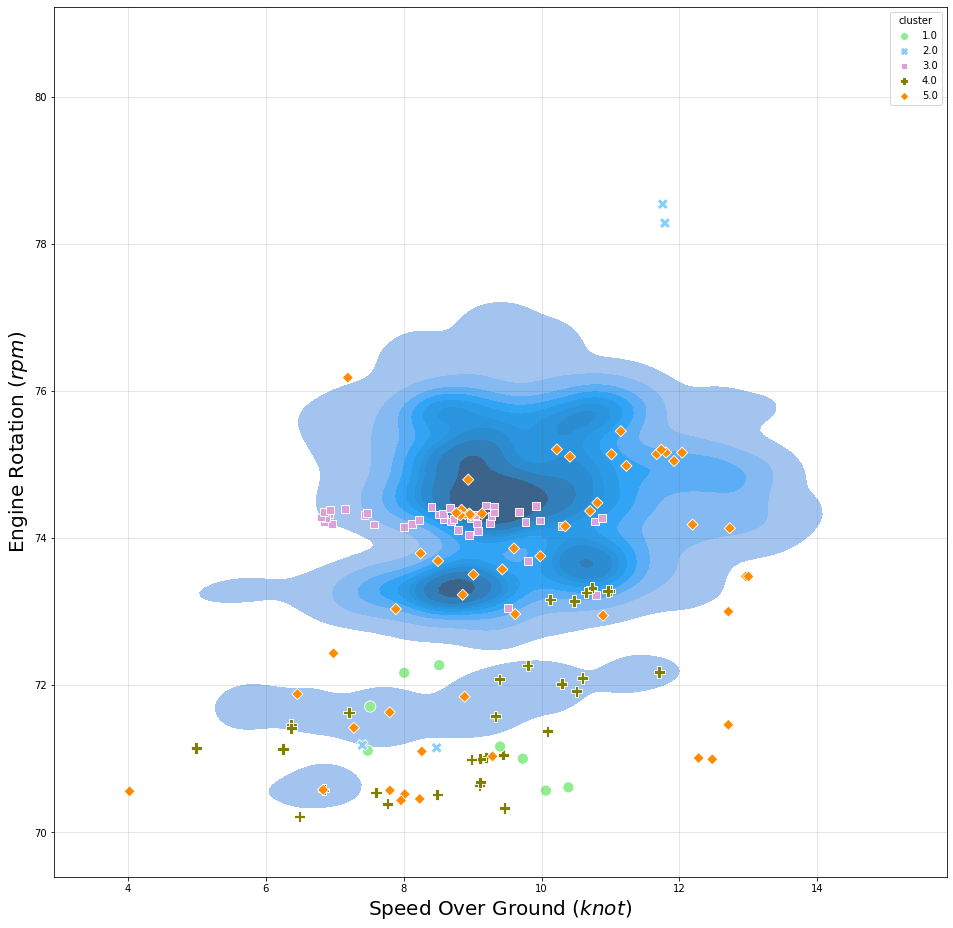

In [280]:
selectPlot(dfPlot, 'speed_vg', 'rpm', 'Speed Over Ground ($knot$)')

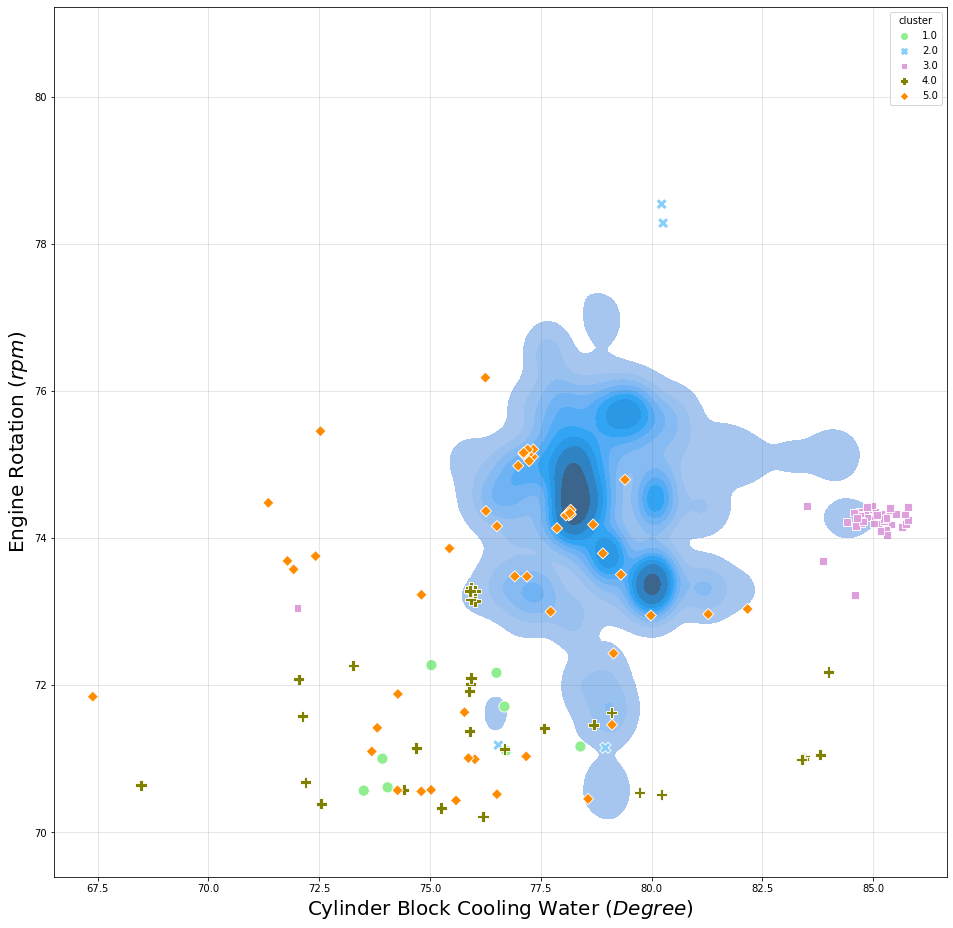

In [281]:
selectPlot(dfPlot, 'cyl_cfw_outlet_temp', 'rpm', 'Cylinder Block Cooling Water ($Degree$)')

In [ ]:
selectPlot(dfPlot, 'lo_inlet_press', 'rpm', 'Lubricant Oil Inlet Pressure ($Bar$)')